In [1]:
import scipy.io.wavfile
import sounddevice as sd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import IPython
import timeit
from matplotlib import patches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.patches as mpatches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict
from scipy import signal
from scipy.signal import (freqz, butter, bessel, cheby1, cheby2, ellip,
                          tf2zpk, zpk2tf, lfilter, buttap, bilinear, cheb2ord, cheb2ap
                          )
from numpy import asarray, tan, array, pi, arange, cos, log10, unwrap, angle
from matplotlib.pyplot import (stem, title, grid, show, plot, xlabel,
                              ylabel, subplot, xscale, figure, xlim,margins)

fs, y = scipy.io.wavfile.read('fastSweep.wav')
y=y.astype(float)/np.max(y)    #cast y to float and normalize between -1 and 1
y=y/2                          # normalize between -0.5 and 0.5, such that noise#  does not cause noisy signal to exceed 1.0
y=y[0:fs]                      # only take one second
Sy=np.linalg.norm(y)**2
sd.play(y,fs)


C:\Users\roco2\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [2]:
noise=np.random.normal(0,1,np.size(y))

In [3]:

def detmult(z):
    s=np.size(z)
    mark=np.zeros(s)
    i=0
    inter=(np.abs(z-z[i])<1e-5)*1.0
    multinter=np.sum(inter)
    mark=mark+inter*multinter
    mult=[[z[i],int(multinter)]]
    
    while i < s :
        i=i+1
        if (i<s) and (mark[i]==0):
            inter=(np.abs(z-z[i])<1e-5)*1.0
            multinter=np.sum(inter)
            mark=mark+inter*multinter
            mult=np.concatenate((mult,[[z[i],int(multinter)]]))
        
    
    return np.array(mult)

def zplane(z, p, ax,filename=None):
    """Plot the complex z-plane given zeros and poles.
    """

 
    unit_circle = patches.Circle((0,0), radius=1, fill=False,
                                 color='black', ls='solid', alpha=0.1)
    ax.add_patch(unit_circle)
    axvline(0, color='0.7')
    axhline(0, color='0.7')

    # Scale axes to fit
    r = 1.5 * np.amax(np.concatenate((np.abs(z), np.abs(p), [1])))
    plt.axis('scaled')
    plt.axis([-r, r, -r, r])
    multz=detmult(z)
    multp=detmult(p)
    nz,throw=multz.shape
    npo,throw=multp.shape
    for i in np.arange(nz):
        plt.plot(multz[i,0].real,multz[i,0].imag,'o',markersize=9,
                 color='b',alpha=0.5)
        if multz[i,1]>1:
            plt.text(multz[i,0].real+r*0.03,multz[i,0].imag+r*0.03,int(multz[i,1]))
    for i in np.arange(npo):
        plt.plot(multp[i,0].real,multp[i,0].imag,'x',markersize=9,
                 color='b',alpha=0.5)
        if multp[i,1]>1:
            plt.text(multp[i,0].real+r*0.03,multp[i,0].imag+r*0.03,int(multp[i,1]))
    
    
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
        print('Pole-zero plot saved to ' + str(filename))


In [4]:
def plot_template(Fr, Att,Fs,axes,togiir,title):
    '''
    plot_template(frequencies, attenuations, Fs)
    frequencies holds an array with the corner frequencies.  It has to start
     with 0 and terminate with Fs/2
        example : low pass Fr=np.array([0,100,110,Fs/2])

    attenuation holds an array with the corresponding attenuations
        example : low pass Att=np.array([2,-60])
                (ripple of 2 dB, Attenuation of -60 dB)
    Fs holds the sampling frequency
    axes [minx (in Hz), maxx (in Hz), min y (in dB), max y (in dB)]
            Very useful to zoom on parts of the frequency response
    togiir = 1 if you design an IIR filter (in the IIR filter, the 
                bandpass maximum gain is 0dB, so the amplitude is between
                0 and 0-ripple in dB.  For FIR filters, the mean
                attenuation is 0 dB)
    title : title of the plot
    
    Committed by L. Deneire, Nov. 20 2018
    '''
    min_y=axes[2]
    togiir=-togiir
    p=[]
        # a polygon inside which the frequency response has to live !
    tog=(Fr.size>4)
        # for internal purpose
    ftype=int(Att[0]>0)
        #ftype : 1 if it starts with low attenuation (e.g. low pass)
        #      : 0 if it starts with high attenuation (e.g. high pass)
    if (ftype==1):
        for i in np.arange(0,Fr.size,2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i+1], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i+1], min_y]]
           else:
                p=p+[[Fr[i-1], min_y],[Fr[min(i+1+int(tog),Fr.size-1)], min_y]]
        for i in np.arange(Fr.size-2,-1,-2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i+1], Att[i//2]/2+Att[i//2]/2*togiir],[Fr[max(0,i-1)], Att[i//2]/2+Att[i//2]/2*togiir]]
           else:     
                p=p+[[Fr[i+1], Att[i//2]],[Fr[i], Att[i//2]],[Fr[i], Att[i//2-1]/2+Att[i//2-1]/2*togiir]]
    else:
        for i in np.arange(0,Fr.size,2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i], Att[i//2]],[Fr[i+1], Att[i//2]],[Fr[i+1], Att[i//2]/2]]
           else:
                p=p+[[Fr[i-1], Att[i//2]/2+Att[i//2]/2*togiir],[Fr[min(i+1+int(tog),Fr.size-1)], Att[i//2]/2+Att[i//2]/2*togiir]]
        for i in np.arange(Fr.size-2,-1,-2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i+1], min_y],[Fr[max(0,i-1)], min_y]]
           else:     
                p=p+[[Fr[i+1], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i], min_y]]
    polygon = mpatches.Polygon(p, closed=True, facecolor='r', alpha=0.3)
    plt.gca().add_patch(polygon)
    plt.title(title)
    plt.xlabel(r'$f$')
    plt.ylabel(r'$|H(f)|$ in dB')
    plt.axis(axes)
    plt.grid();

In [5]:
def processfir(firdenoise,ynoisy,order=1):

#show filter  
    w, Hk = signal.freqz(firdenoise,1)
    plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
    plt.title('shape of the fir filter')
    plt.show()
    plt.plot(w, np.unwrap(np.angle(Hk)))
    plt.title('Phase')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$\varphi (\Omega)$ in rad')
    plt.show()
    print ('order of the filter: ',order)
#convolve and calculate number of operations
    ydenoise=np.convolve(firdenoise,ynoisy)
    mytime=timeit.timeit(lambda: np.convolve(firdenoise,ynoisy),number=10)
    time_to_mult = timeit.timeit(stmt='2147483648*2147483648',number=10)
    print('Number of multiplications to filter= '+str(int(mytime/time_to_mult))+' \n')

    ydenoise=ydenoise[2750:y.size+2750:]  # take the group delay into account# 
#for SNR
    f,Pyy_den=signal.periodogram(y,fs)
    plt.semilogy(f, Pyy_den)
    plt.ylim([1e-9, 1])

    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('power spectrum of the input')
    plt.show()
    f,Pyy_den=signal.periodogram(ynoisy,fs)
    plt.semilogy(f, Pyy_den)
    plt.ylim([1e-9, 1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('power spectrum of the noisy signal')
    plt.show()
    f,Pyy_den=signal.periodogram(ydenoise,fs)
    plt.semilogy(f, Pyy_den)
    plt.ylim([1e-9, 1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('power spectrum of the denoised signal')
    plt.show()

    print('power of y = ',20*np.log10(np.linalg.norm(y)), 'dB')
    print('SNR before denoising = ',20*np.log10(np.linalg.norm(y)/np.linalg.norm(y-ynoisy)),' dB')
    print('SNR after denoising = ',20*np.log10(np.linalg.norm(y)/np.linalg.norm(y-ydenoise)),' dB')
    sd.play(ydenoise,fs)

In [6]:
def processiir(a,b,z,p,k,ynoisy):
    w, h = signal.freqz(b, a)
    plt.plot(w/(2*np.pi)*fs, 20 * np.log10(abs(h)))
   # plt.xscale('log')
    plt.title('shape of filter')
    plt.show()
    plt.plot(w, np.unwrap(np.angle(h)))
    plt.title('Phase')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$\varphi (\Omega)$ in rad')
    plt.show()
    print ('order of the filter: ',a.size)

    title("pôles et zéros")
    ax=plt.subplot(1, 1, 1)
    zplane(z,p,ax)
    
    ydenoise=signal.filtfilt(b,a,ynoisy)
    mytime=timeit.timeit(lambda: signal.filtfilt(b,a,ynoisy),number=10)
    time_to_mult = timeit.timeit(stmt='2147483648*2147483648',number=10)
    print('Number of multiplications to filter= '+str(int(mytime/time_to_mult))+' \n')

    w, Hk = signal.freqz(ydenoise,1)
    plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
    plt.show()
    
    f,Pyy_den=signal.periodogram(y,fs)
    plt.semilogy(f, Pyy_den)
    plt.ylim([1e-9, 1])

    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('power spectrum of the input')
    plt.show()
    f,Pyy_den=signal.periodogram(ynoisy,fs)
    plt.semilogy(f, Pyy_den)
    plt.ylim([1e-9, 1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('power spectrum of the noisy signal')
    plt.show()
    f,Pyy_den=signal.periodogram(ydenoise,fs)
    plt.semilogy(f, Pyy_den)
    plt.ylim([1e-9, 1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('power spectrum of the denoised signal')
    plt.show()
    print('power of y = ',20*np.log10(np.linalg.norm(y)), 'dB')
    print('SNR before denoising = ',20*np.log10(np.linalg.norm(y)/np.linalg.norm(y-ynoisy)),' dB')
    print('SNR after denoising = ',20*np.log10(np.linalg.norm(y)/np.linalg.norm(y-ydenoise)),' dB')
    
    sd.play(ydenoise,fs)

# Remez

## Bruit

### Basse frequence

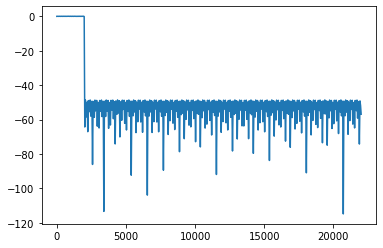

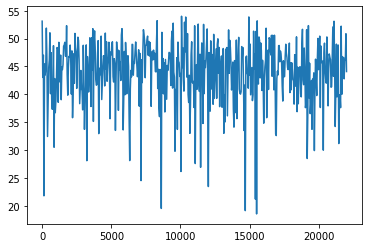

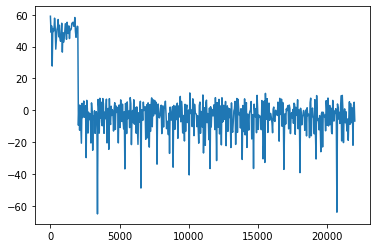

In [7]:
bfirnoise=signal.remez(5501,np.array([0,1980,2000,fs/2])/fs,np.array([1.0,0.0]))
w, Hk = signal.freqz(bfirnoise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
bfiltered_noise=2*np.convolve(bfirnoise,noise)

w, Hk = signal.freqz(noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

w, Hk = signal.freqz(bfiltered_noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

### Passe bande

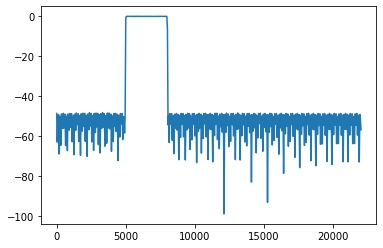

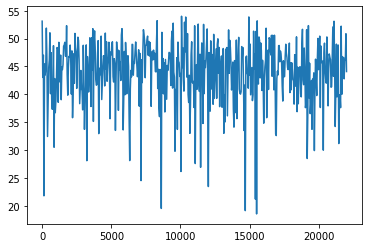

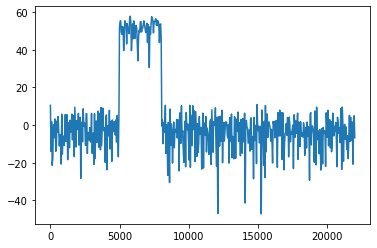

In [8]:
pfirnoise=signal.remez(5501,np.array([0,4980,5000,8000,8020,fs/2])/fs,np.array([0.0,1.0,0.0]),type='bandpass')
w, Hk = signal.freqz(pfirnoise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
pfiltered_noise=2*np.convolve(pfirnoise,noise)

w, Hk = signal.freqz(noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

w, Hk = signal.freqz(pfiltered_noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

### Haute frequence

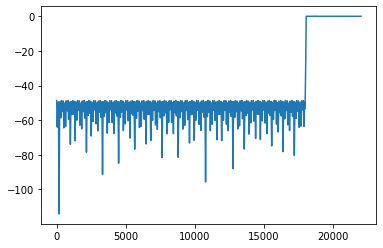

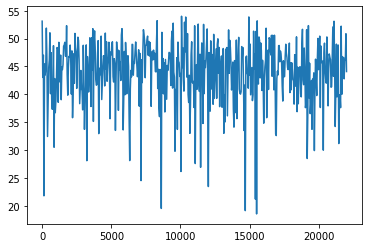

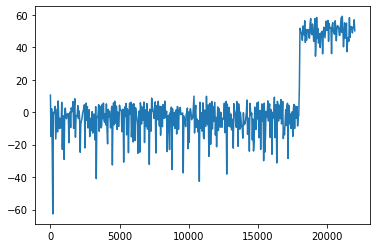

In [9]:
hfirnoise=signal.remez(5501,np.array([0,18000,18020,fs/2])/fs,np.array([0.0,1.0]))
w, Hk = signal.freqz(hfirnoise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
hfiltered_noise=2*np.convolve(hfirnoise,noise)

w, Hk = signal.freqz(noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

w, Hk = signal.freqz(hfiltered_noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

## Ajout du bruit au signal

### Basse frequence

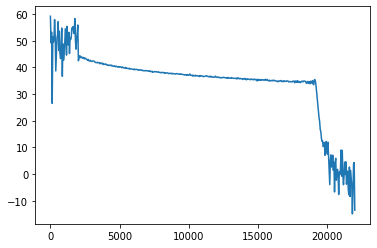

In [10]:
bynoisy=y+bfiltered_noise[2750:y.size+2750:]
w, Hk = signal.freqz(bynoisy,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
sd.play(bynoisy,fs)

### Passe bande

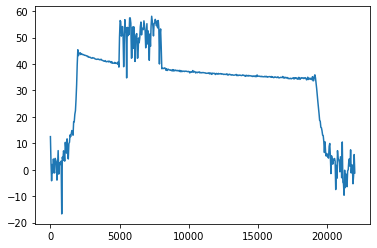

In [11]:
pynoisy=y+pfiltered_noise[2750:y.size+2750:]
w, Hk = signal.freqz(pynoisy,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
sd.play(pynoisy,fs)

### Haute frequence

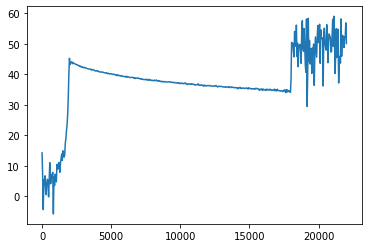

In [12]:
hynoisy=y+hfiltered_noise[2750:y.size+2750:]
w, Hk = signal.freqz(hynoisy,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
sd.play(hynoisy,fs)

## Résultats

### Basse fréquence

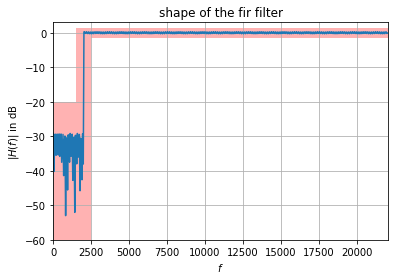

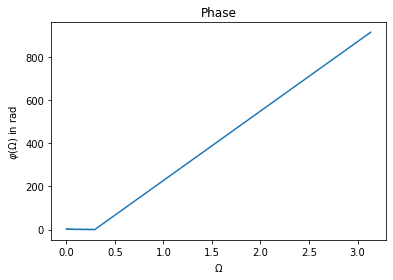

order of the filter:  5501
Number of multiplications to filter= 1342726 



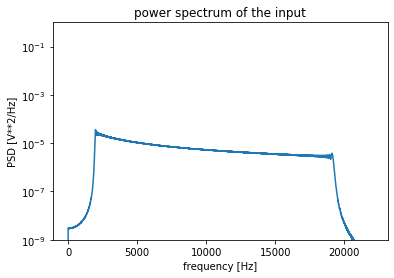

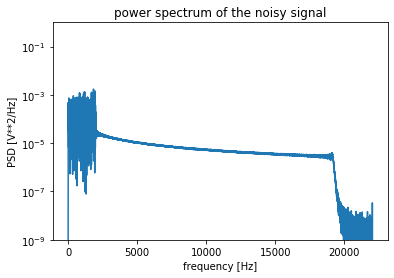

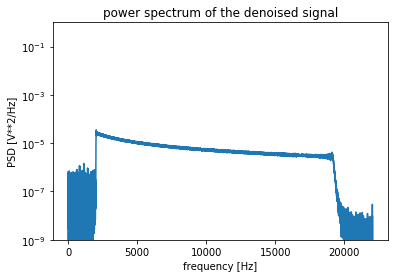

power of y =  37.29852472842241 dB
SNR before denoising =  -4.4906223689462905  dB
SNR after denoising =  16.776925152463424  dB


In [13]:
plot_template(np.array([fs/2,2500,1500,0]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'fir filter')
bfirdenoise=signal.remez(5501,np.array([0,2010,2020,fs/2])/fs,np.array([0.0,1.0]))
processfir(bfirdenoise,bynoisy,5501)

### Passe bande

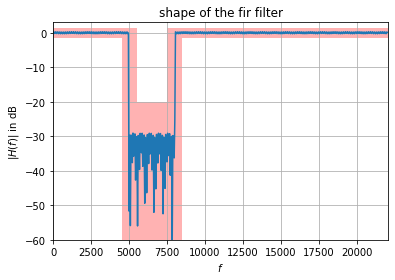

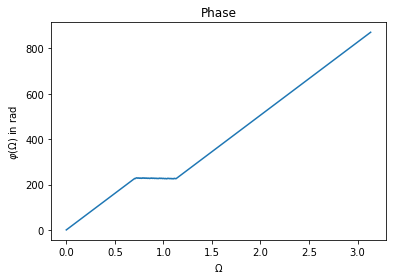

order of the filter:  5501
Number of multiplications to filter= 1063256 



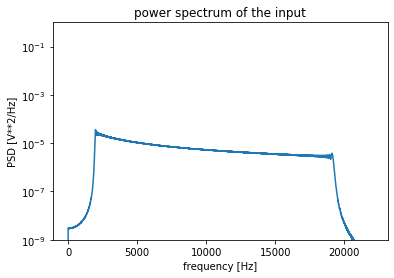

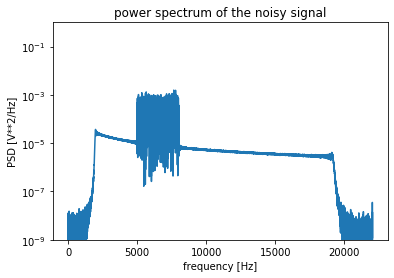

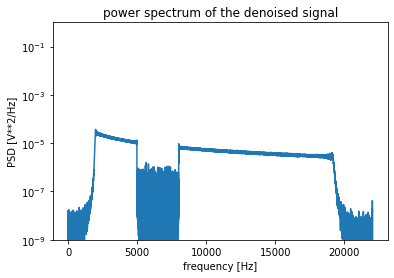

power of y =  37.29852472842241 dB
SNR before denoising =  -6.628224962111064  dB
SNR after denoising =  6.8027697714797934  dB


In [14]:
plot_template(np.array([0,4500,5500,7500,8500,fs/2]), np.array([3,-20,3]),fs/2,[0, fs/2, -60, 3],0,'fir filter')
pfirdenoise=signal.remez(5501,np.array([0,4980,4990,8010,8020,fs/2])/fs,np.array([1.0,0.0,1.0]),type='bandpass')
processfir(pfirdenoise,pynoisy,5501)

### Haute fréquence

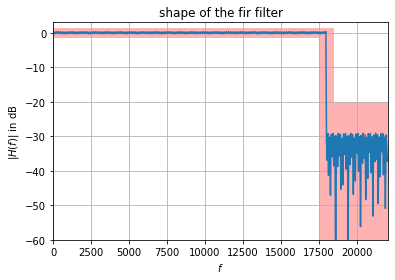

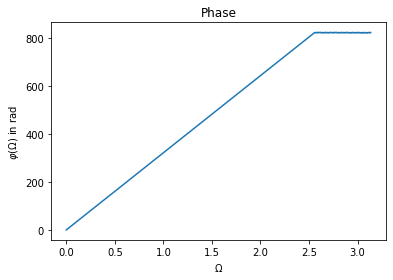

order of the filter:  5501
Number of multiplications to filter= 1049476 



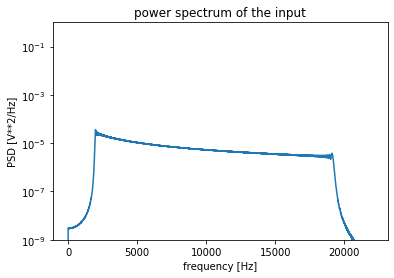

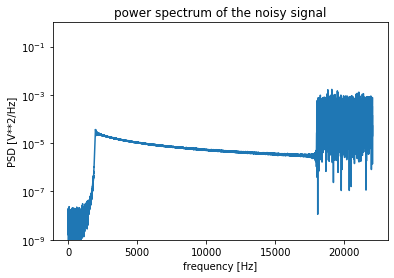

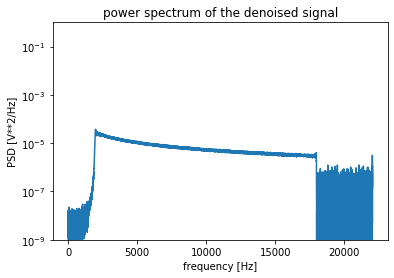

power of y =  37.29852472842241 dB
SNR before denoising =  -7.870659773258329  dB
SNR after denoising =  14.613114911371891  dB


In [15]:
plot_template(np.array([0,17500,18500,fs/2]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'fir filter')
hfirdenoise=signal.remez(5501,np.array([0,17990,18000,fs/2])/fs,np.array([1.0,0.0]))
processfir(hfirdenoise,hynoisy,5501)

# Kaiser

Décommenter les sections suivantes pour générer un bruit filtré par un filtre de Kaiser

## Bruit

### Basse frequence

In [16]:
'''
bfirnoise=signal.firwin(5510, np.array([2000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='lowpass')
w, Hk = signal.freqz(bfirnoise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
bfiltered_noise=2*np.convolve(bfirnoise,noise)
w, Hk = signal.freqz(noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

w, Hk = signal.freqz(bfiltered_noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
'''

"\nbfirnoise=signal.firwin(5510, np.array([2000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='lowpass')\nw, Hk = signal.freqz(bfirnoise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\nbfiltered_noise=2*np.convolve(bfirnoise,noise)\nw, Hk = signal.freqz(noise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\n\nw, Hk = signal.freqz(bfiltered_noise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\n"

### Passe bande

In [17]:
'''
pfirnoise=signal.firwin(5510, np.array([5000,8000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='bandpass')
w, Hk = signal.freqz(pfirnoise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
pfiltered_noise=2*np.convolve(pfirnoise,noise)
w, Hk = signal.freqz(noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
w, Hk = signal.freqz(pfiltered_noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
'''

"\npfirnoise=signal.firwin(5510, np.array([5000,8000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='bandpass')\nw, Hk = signal.freqz(pfirnoise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\npfiltered_noise=2*np.convolve(pfirnoise,noise)\nw, Hk = signal.freqz(noise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\nw, Hk = signal.freqz(pfiltered_noise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\n"

### Haute frequence

In [18]:
'''
hfirnoise=signal.firwin(5511, np.array([18000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='highpass')
w, Hk = signal.freqz(hfirnoise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
hfiltered_noise=2*np.convolve(hfirnoise,noise)

w, Hk = signal.freqz(noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()

w, Hk = signal.freqz(hfiltered_noise,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
'''

"\nhfirnoise=signal.firwin(5511, np.array([18000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='highpass')\nw, Hk = signal.freqz(hfirnoise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\nhfiltered_noise=2*np.convolve(hfirnoise,noise)\n\nw, Hk = signal.freqz(noise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\n\nw, Hk = signal.freqz(hfiltered_noise,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\n"

## Ajout du bruit au signal

### Basse frequence

In [19]:
'''
bynoisy=y+bfiltered_noise[2750:y.size+2750:]
w, Hk = signal.freqz(bynoisy,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
sd.play(bynoisy,fs)
'''

'\nbynoisy=y+bfiltered_noise[2750:y.size+2750:]\nw, Hk = signal.freqz(bynoisy,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\nsd.play(bynoisy,fs)\n'

### Passe bande

In [20]:
'''
pynoisy=y+pfiltered_noise[2750:y.size+2750:]
w, Hk = signal.freqz(pynoisy,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
sd.play(pynoisy,fs)
'''

'\npynoisy=y+pfiltered_noise[2750:y.size+2750:]\nw, Hk = signal.freqz(pynoisy,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\nsd.play(pynoisy,fs)\n'

### Haute frequence

In [21]:
'''
hynoisy=y+hfiltered_noise[2750:y.size+2750:]
w, Hk = signal.freqz(hynoisy,1)
plt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))
plt.show()
sd.play(hynoisy,fs)
'''

'\nhynoisy=y+hfiltered_noise[2750:y.size+2750:]\nw, Hk = signal.freqz(hynoisy,1)\nplt.plot(w/(2*np.pi)*fs, 20*np.log10(np.abs(Hk)))\nplt.show()\nsd.play(hynoisy,fs)\n'

## Résultats

### Basse fréquence

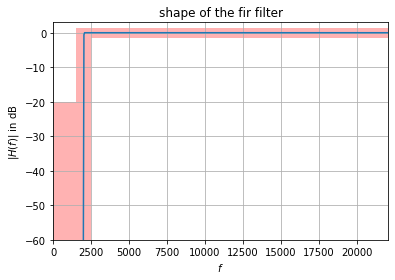

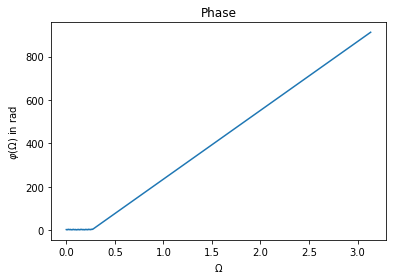

order of the filter:  5511
Number of multiplications to filter= 809210 



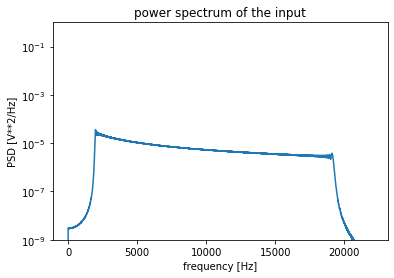

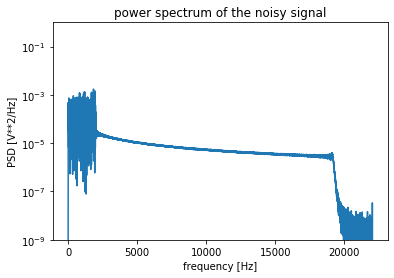

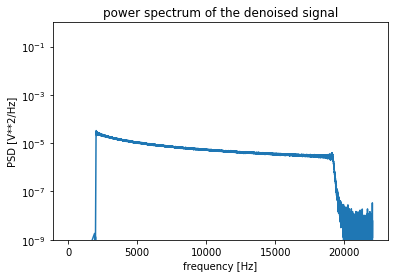

power of y =  37.29852472842241 dB
SNR before denoising =  -4.4906223689462905  dB
SNR after denoising =  -3.673071153438875  dB


In [22]:
plot_template(np.array([fs/2,2500,1500,0]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'fir filter')
bfirdenoise=signal.firwin(5511, np.array([2010]), window=('kaiser',14),scale=False, fs=fs, pass_zero='highpass')
processfir(bfirdenoise,bynoisy,5511)

### Passe bande

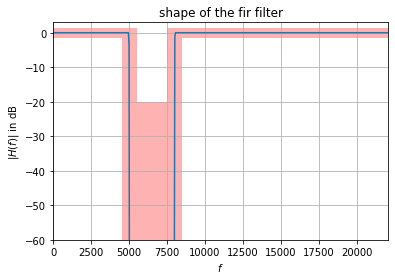

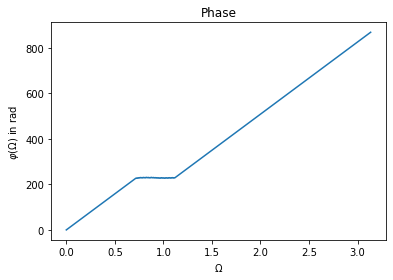

order of the filter:  5511
Number of multiplications to filter= 1663336 



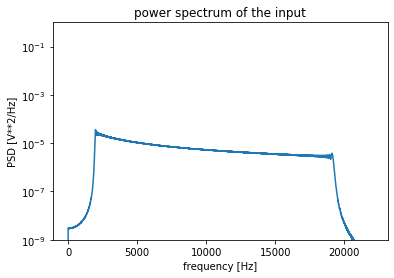

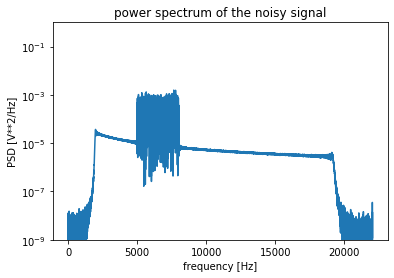

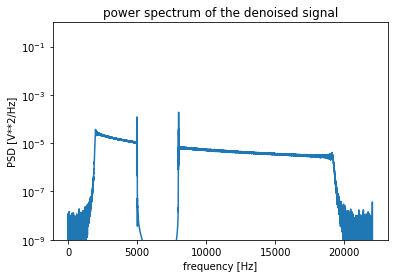

power of y =  37.29852472842241 dB
SNR before denoising =  -6.628224962111064  dB
SNR after denoising =  -3.2084891707289116  dB


In [23]:
plot_template(np.array([0,4500,5500,7500,8500,fs/2]), np.array([3,-20,3]),fs/2,[0, fs/2, -60, 3],0,'fir filter')
pfirdenoise=signal.firwin(5511, np.array([5000,8000]), window=('kaiser',14),scale=False, fs=fs, pass_zero='bandstop')
processfir(pfirdenoise,pynoisy,5511)

### Haute fréquence

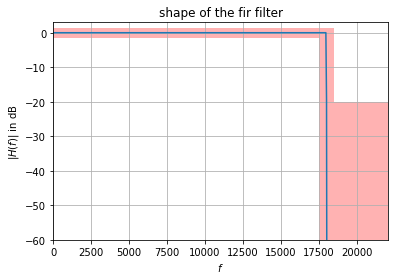

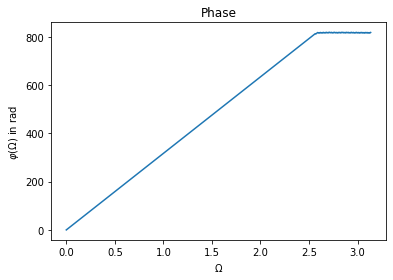

order of the filter:  5511
Number of multiplications to filter= 1158550 



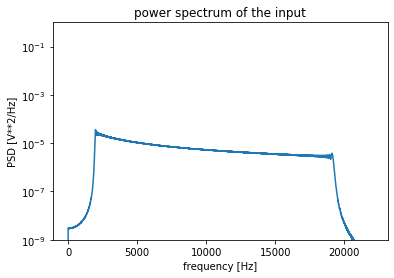

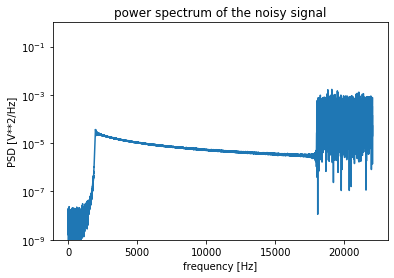

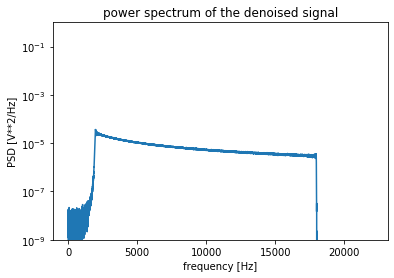

power of y =  37.29852472842241 dB
SNR before denoising =  -7.870659773258329  dB
SNR after denoising =  -3.722149523838152  dB


In [24]:
plot_template(np.array([0,17500,18500,fs/2]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'fir filter')
hfirdenoise=signal.firwin(5511, np.array([17990]), window=('kaiser',14),scale=False, fs=fs, pass_zero='lowpass')
processfir(hfirdenoise,hynoisy,5511)

### Remarque
On remarque que le filtre de kaiser filtre très bien, et qu'on entend quasiement plus le bruit, mais comme il retire aussi le signal original présent dans le bruit, le SNR n'est pas très bon.

# Butterworth

### Basse frequence

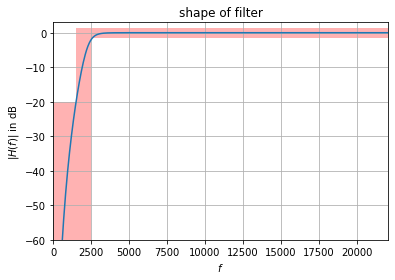

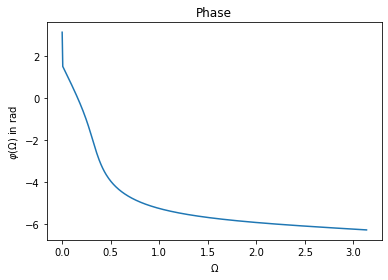

order of the filter:  6


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


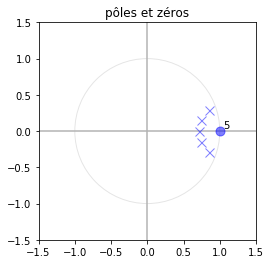

Number of multiplications to filter= 46456 



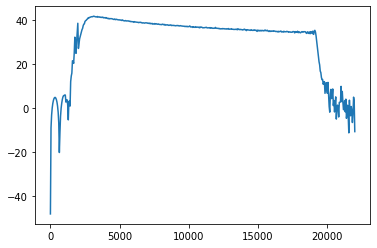

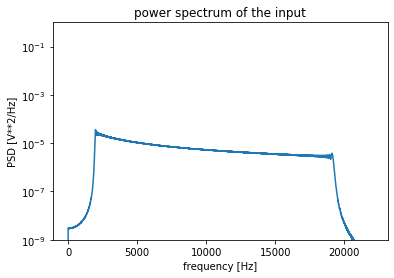

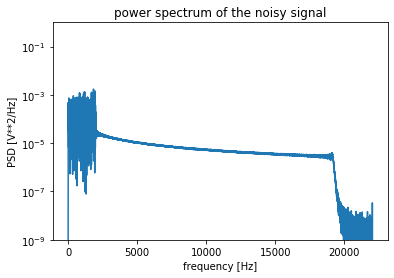

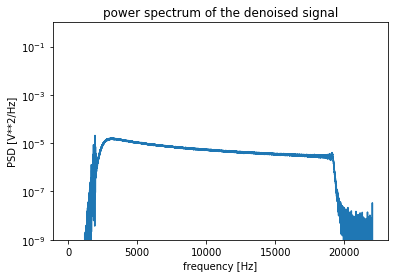

power of y =  37.29852472842241 dB
SNR before denoising =  -4.4906223689462905  dB
SNR after denoising =  12.223580240574975  dB


In [25]:
plot_template(np.array([fs/2,2500,1500,0]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 2, 10, ftype='butter', output='ba'))
z,p,k=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 2, 10, ftype='butter', output='zpk'))
processiir(a,b,z,p,k,bynoisy)

### Passe bande

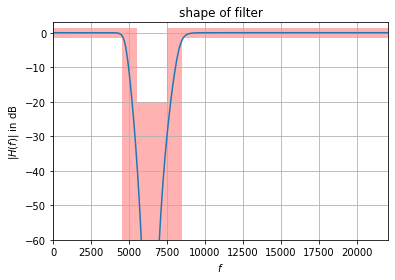

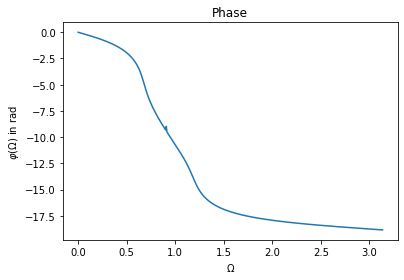

order of the filter:  13


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


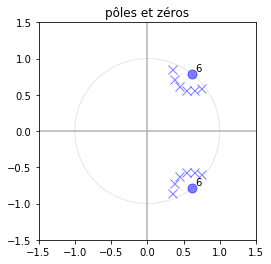

Number of multiplications to filter= 39101 



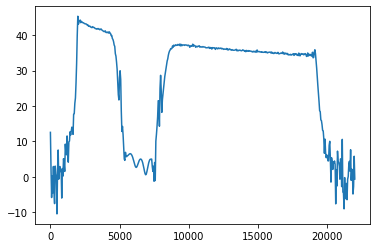

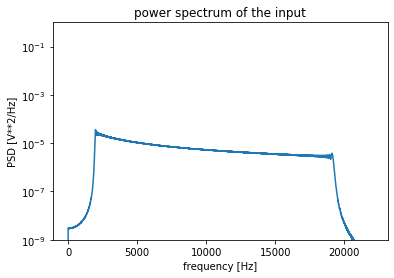

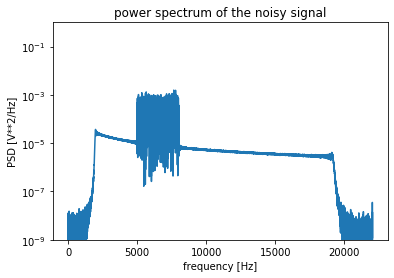

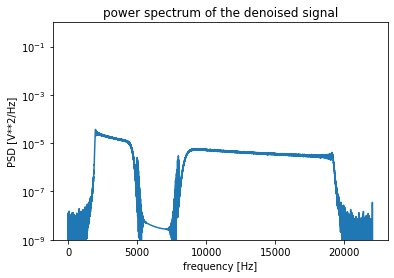

power of y =  37.29852472842241 dB
SNR before denoising =  -6.628224962111064  dB
SNR after denoising =  6.29556111616864  dB


In [26]:
plot_template(np.array([0,4500,5500,7500,8500,fs/2]), np.array([3,-20,3]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign([10/(fs/2),8500/(fs/2)], [5000/(fs/2),8000/(fs/2)], 2, 10, ftype='butter', output='ba'))
z,p,k=(signal.iirdesign([10/(fs/2),8500/(fs/2)], [5000/(fs/2),8000/(fs/2)], 2, 10, ftype='butter', output='zpk'))
processiir(a,b,z,p,k,pynoisy)

### Haute frequence

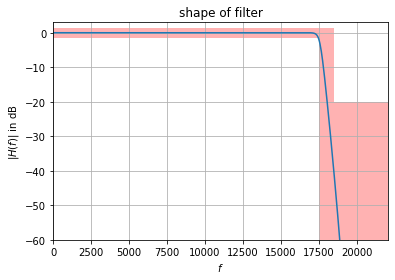

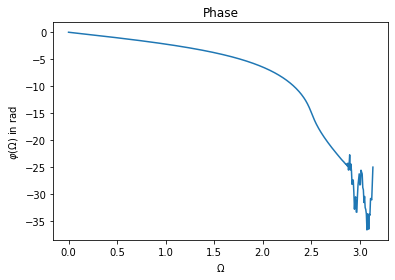

order of the filter:  20


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


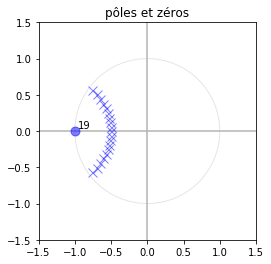

Number of multiplications to filter= 39620 



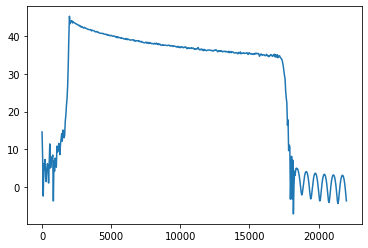

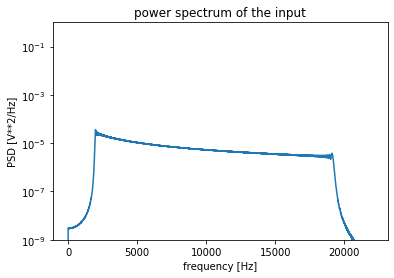

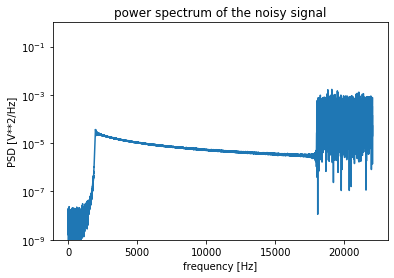

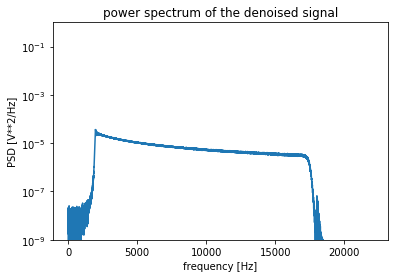

power of y =  37.29852472842241 dB
SNR before denoising =  -7.870659773258329  dB
SNR after denoising =  14.139897287849008  dB


In [27]:
plot_template(np.array([0,17500,18500,fs/2]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(17500/(fs/2), 17800/(fs/2), 2, 10, ftype='butter', output='ba'))
z,p,k=(signal.iirdesign(17500/(fs/2), 17800/(fs/2), 2, 10, ftype='butter', output='zpk'))
processiir(a,b,z,p,k,hynoisy)

# Chebyshev I

### Basse frequence

C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


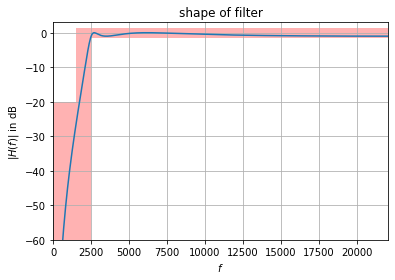

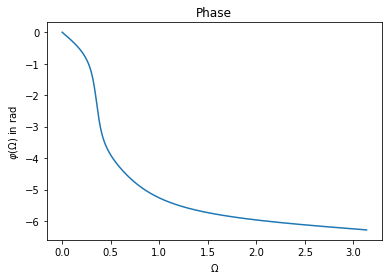

order of the filter:  5


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


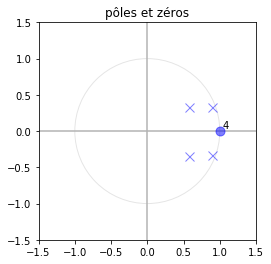

Number of multiplications to filter= 17826 



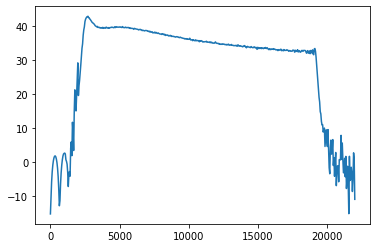

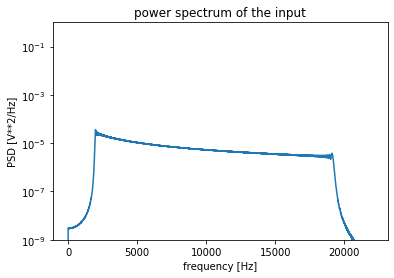

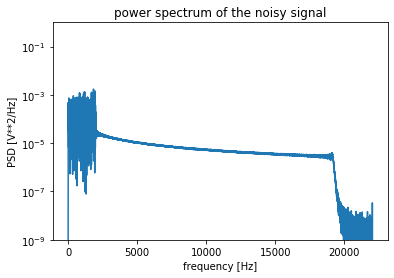

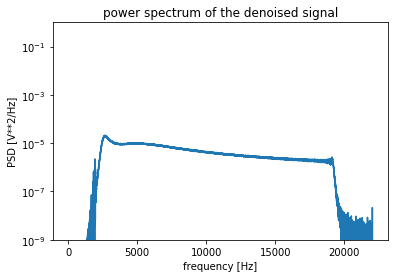

power of y =  37.29852472842241 dB
SNR before denoising =  -4.4906223689462905  dB
SNR after denoising =  10.919233325702798  dB


In [28]:
plot_template(np.array([fs/2,2500,1500,0]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 1, 10, ftype='cheby1', output='ba'))
z,p,k=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 1, 10, ftype='cheby1', output='zpk'))
processiir(a,b,z,p,k,bynoisy)

### Passe bande

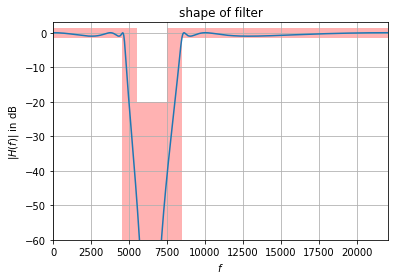

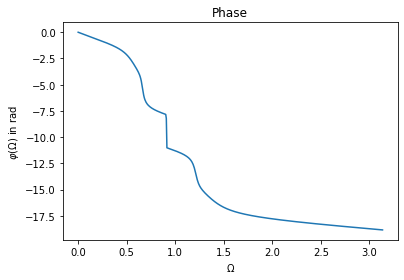

order of the filter:  11


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


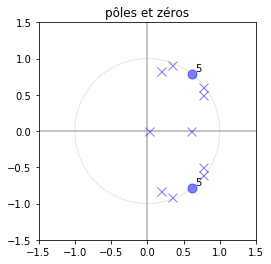

Number of multiplications to filter= 90233 



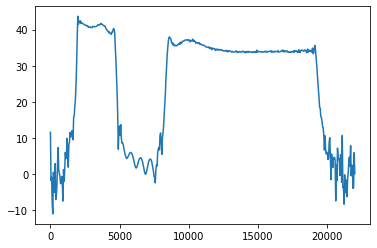

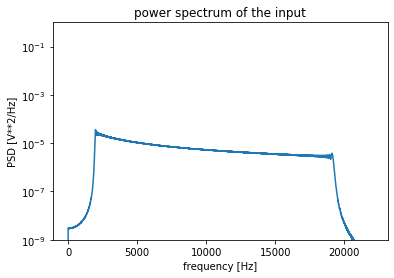

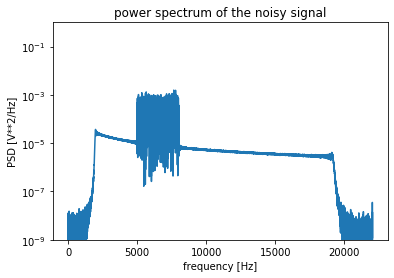

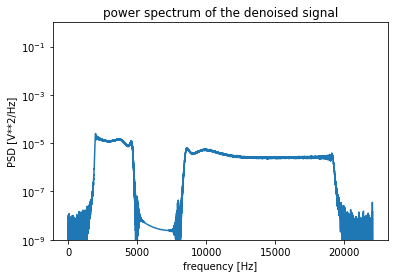

power of y =  37.29852472842241 dB
SNR before denoising =  -6.628224962111064  dB
SNR after denoising =  5.838484769628965  dB


In [29]:
plot_template(np.array([0,4500,5500,7500,8500,fs/2]), np.array([3,-20,3]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign([10/(fs/2),8500/(fs/2)], [5000/(fs/2),8000/(fs/2)], 1, 15, ftype='cheby1', output='ba'))
z,p,k=(signal.iirdesign([10/(fs/2),8500/(fs/2)], [5000/(fs/2),8000/(fs/2)], 1, 15, ftype='cheby1', output='zpk'))
processiir(a,b,z,p,k,pynoisy)

### Haute frequence

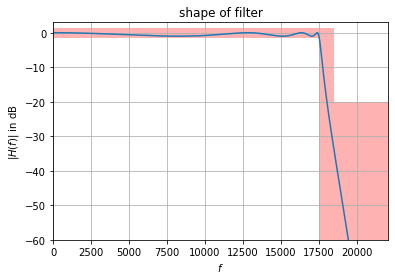

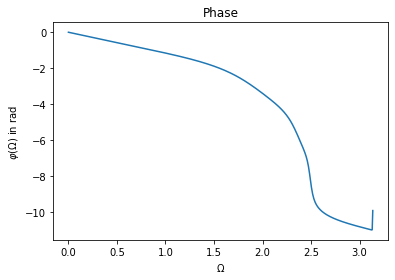

order of the filter:  8


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


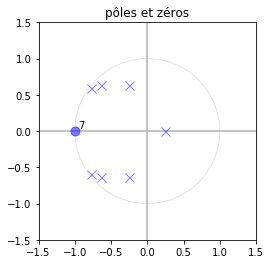

Number of multiplications to filter= 8130 



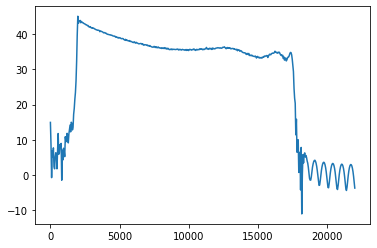

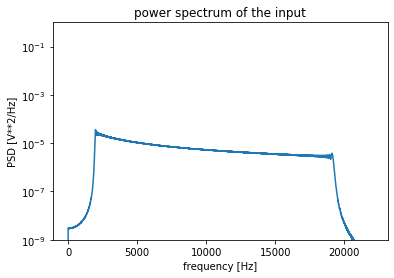

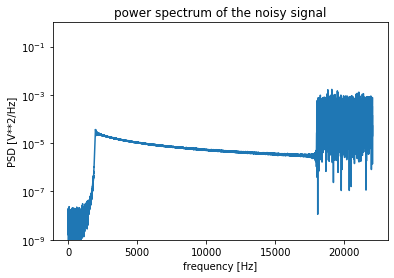

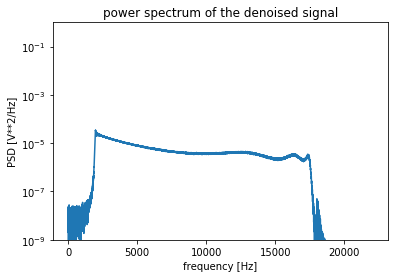

power of y =  37.29852472842241 dB
SNR before denoising =  -7.870659773258329  dB
SNR after denoising =  12.667009000983292  dB


In [30]:
plot_template(np.array([0,17500,18500,fs/2]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(17500/(fs/2), 17800/(fs/2), 1, 10, ftype='cheby1', output='ba'))
z,p,k=(signal.iirdesign(17500/(fs/2), 17800/(fs/2), 1, 10, ftype='cheby1', output='zpk'))
processiir(a,b,z,p,k,hynoisy)

# Chebyshev II

### Basse frequence

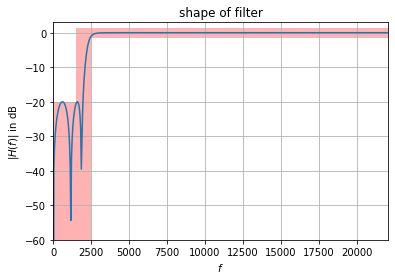

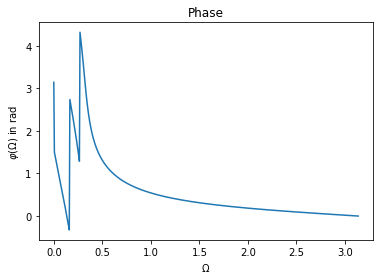

order of the filter:  6


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


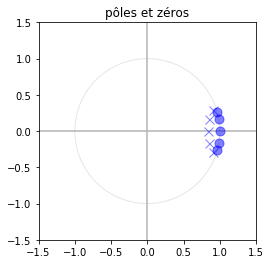

Number of multiplications to filter= 21948 



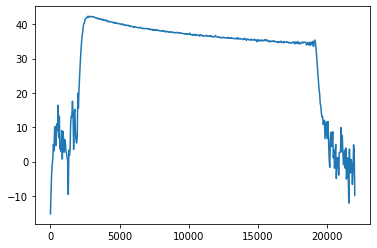

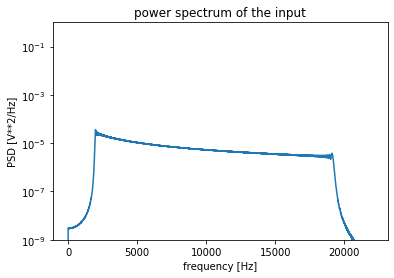

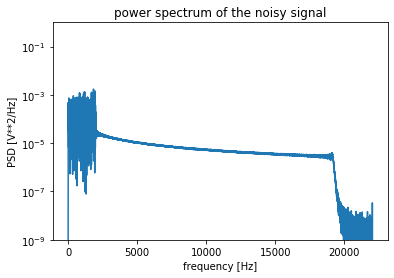

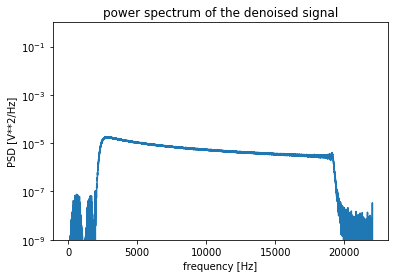

power of y =  37.29852472842241 dB
SNR before denoising =  -4.4906223689462905  dB
SNR after denoising =  12.120636582185707  dB


In [31]:
plot_template(np.array([fs/2,2500,1500,0]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 1, 20, ftype='cheby2', output='ba'))
z,p,k=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 1, 20, ftype='cheby2', output='zpk'))
processiir(a,b,z,p,k,bynoisy)

### Passe bande

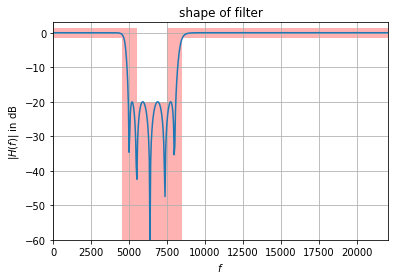

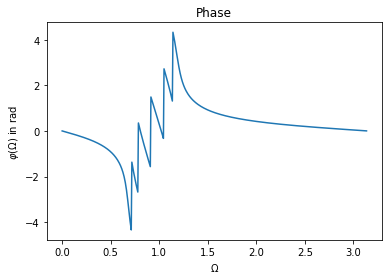

order of the filter:  11


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


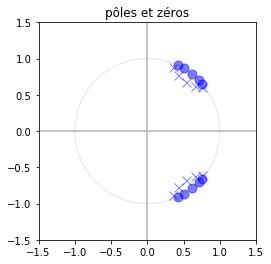

Number of multiplications to filter= 14068 



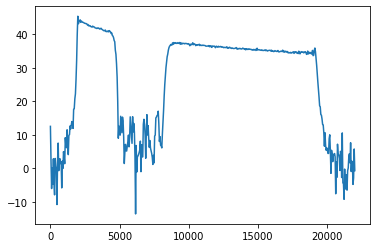

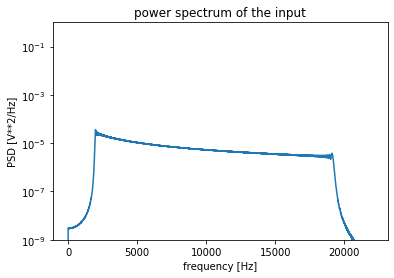

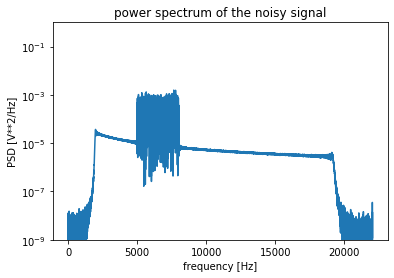

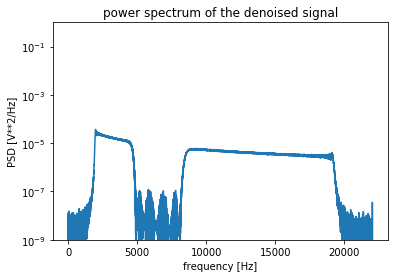

power of y =  37.29852472842241 dB
SNR before denoising =  -6.628224962111064  dB
SNR after denoising =  6.215089993505753  dB


In [32]:
plot_template(np.array([0,4500,5500,7500,8500,fs/2]), np.array([3,-20,3]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign([10/(fs/2),8400/(fs/2)], [5000/(fs/2),8000/(fs/2)], 3, 20, ftype='cheby2', output='ba'))
z,p,k=(signal.iirdesign([10/(fs/2),8400/(fs/2)], [5000/(fs/2),8000/(fs/2)], 3, 20, ftype='cheby2', output='zpk'))
processiir(a,b,z,p,k,pynoisy)

### Haute frequence

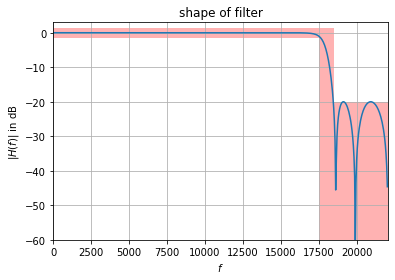

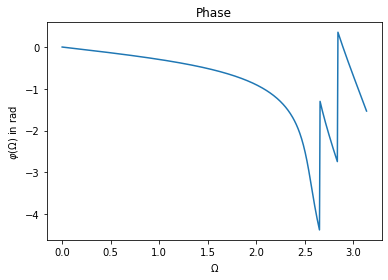

order of the filter:  6


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


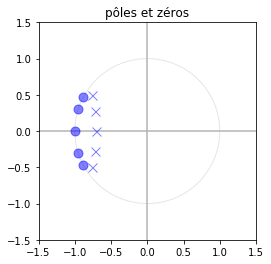

Number of multiplications to filter= 14729 



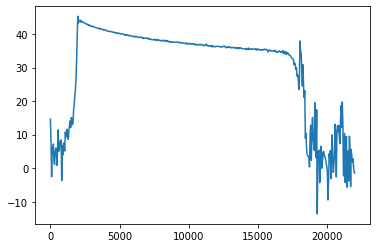

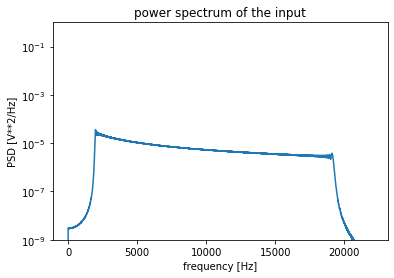

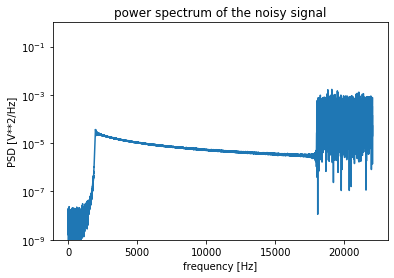

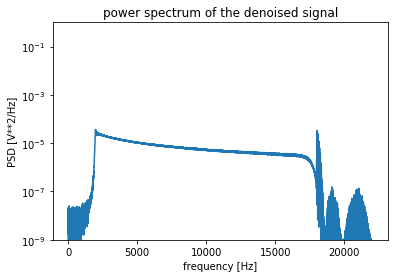

power of y =  37.29852472842241 dB
SNR before denoising =  -7.870659773258329  dB
SNR after denoising =  13.867710945820363  dB


In [33]:
plot_template(np.array([0,17500,18500,fs/2]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(17700/(fs/2), 18500/(fs/2), 2, 20, ftype='cheby2', output='ba'))
z,p,k=(signal.iirdesign(17700/(fs/2), 18500/(fs/2), 2, 20, ftype='cheby2', output='zpk'))
processiir(a,b,z,p,k,hynoisy)

# Elliptique

### Basse frequence

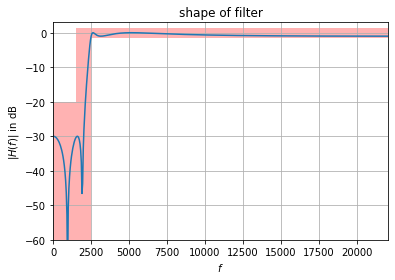

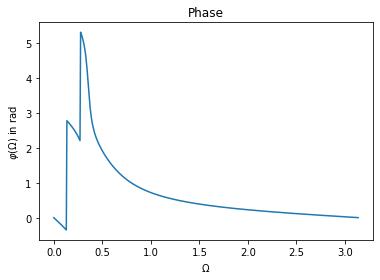

order of the filter:  5


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


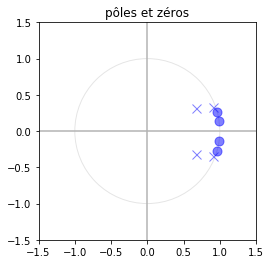

Number of multiplications to filter= 26400 



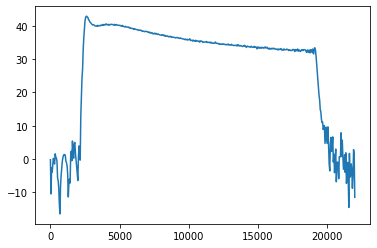

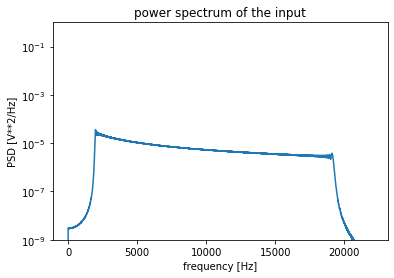

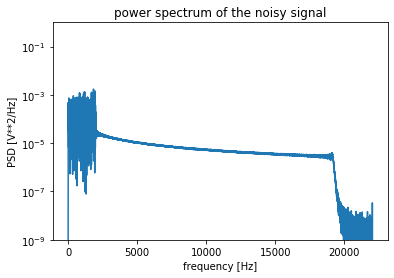

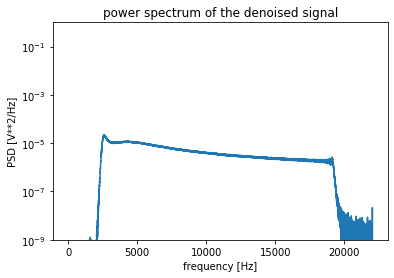

power of y =  37.29852472842241 dB
SNR before denoising =  -4.4906223689462905  dB
SNR after denoising =  9.87861583153763  dB


In [34]:
plot_template(np.array([fs/2,2500,1500,0]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 1, 30, ftype='ellip', output='ba'))
z,p,k=(signal.iirdesign(2500/(fs/2), 1900/(fs/2), 1, 30, ftype='ellip', output='zpk'))
processiir(a,b,z,p,k,bynoisy)

### Passe bande

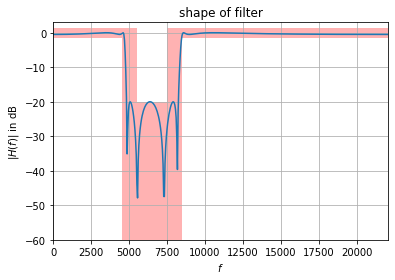

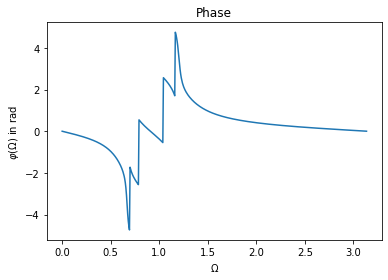

order of the filter:  9


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


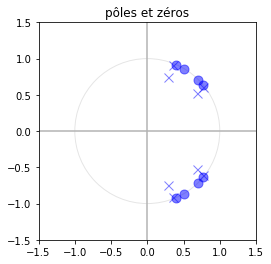

Number of multiplications to filter= 18462 



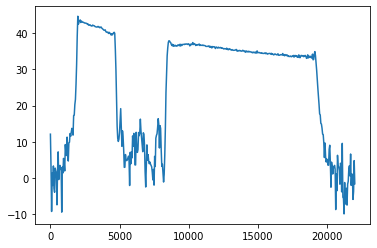

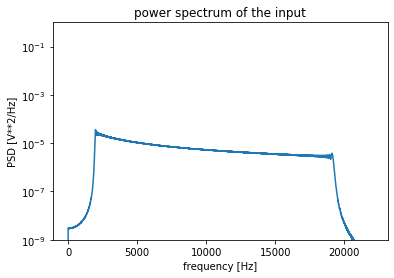

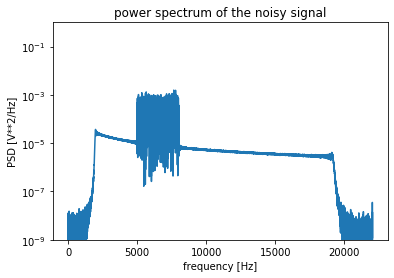

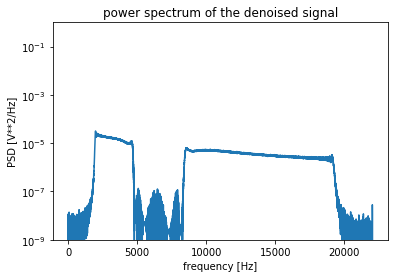

power of y =  37.29852472842241 dB
SNR before denoising =  -6.628224962111064  dB
SNR after denoising =  6.046615047529818  dB


In [35]:
plot_template(np.array([0,4500,5500,7500,8500,fs/2]), np.array([3,-20,3]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign([10/(fs/2),8500/(fs/2)], [5000/(fs/2),8000/(fs/2)], 0.5, 20, ftype='ellip', output='ba'))
z,p,k=(signal.iirdesign([10/(fs/2),8500/(fs/2)], [5000/(fs/2),8000/(fs/2)], 0.5, 20, ftype='ellip', output='zpk'))
processiir(a,b,z,p,k,pynoisy)

### Haute frequence

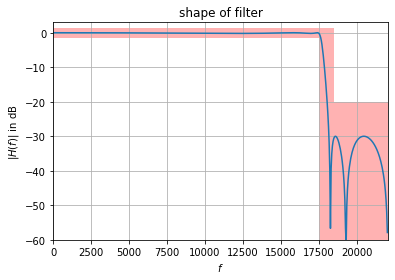

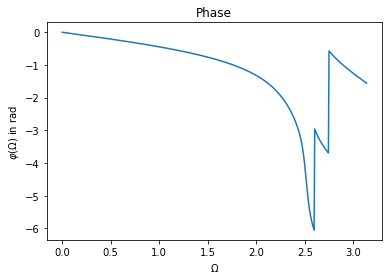

order of the filter:  6


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


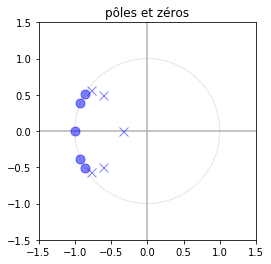

Number of multiplications to filter= 13243 



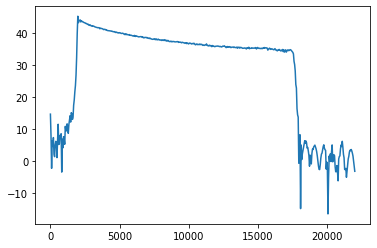

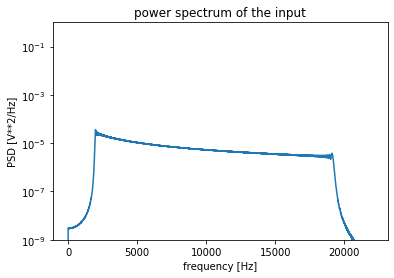

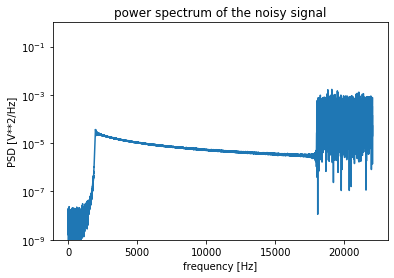

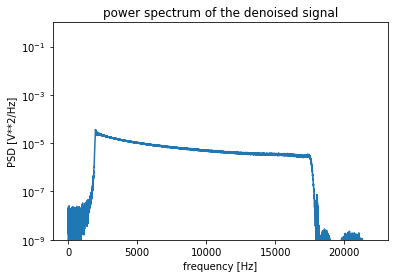

power of y =  37.29852472842241 dB
SNR before denoising =  -7.870659773258329  dB
SNR after denoising =  14.376945316708573  dB


In [36]:
plot_template(np.array([0,17500,18500,fs/2]), np.array([3,-20]),fs/2,[0, fs/2, -60, 3],0,'iir filter')
b,a=(signal.iirdesign(17500/(fs/2), 18500/(fs/2), 0.2, 30, ftype='ellip', output='ba'))
z,p,k=(signal.iirdesign(17500/(fs/2), 18500/(fs/2), 0.2, 30, ftype='ellip', output='zpk'))
processiir(a,b,z,p,k,hynoisy)

# Conclusion

Quand on compare les SNR, on remarque que le meilleur filtre est celui de Remez. Le problème est que son ordre est beaucoup trop élevé et qu'il demande beaucoup trop de calcul.

On va plutot se concentrer sur les IIR qui ont un ordre moins élevé et demmandent moins de calcul.

En comparant les SNR, On remarque que Butterworth a les meilleurs résultats.

En comparant les ordres des filtres, l'Elliptique s'en sort le mieux. 

En comparant les complexités de calcul, l'Elliptique est aussi très bon, mais Butterworth et Chebyshev 1 et 2 font mieux en basse fréquence.

Si on doit faire un compromis entre tous ses facteurs, Chebyshev 1 semble etre une bonne solution. Si on doit se fier à l'ecoute du son, je trouve que l'Elliptique est une bonne solution. 

Le problème avec les fitres effectués, c'est qu'en atténuant autant le bruit, on atténue aussi le signal de départ, et à l'oreille ça s'entend. Il faut donc faire attention à ne pas trop atténuer, quitte à garder un bruit de fond. 

On remarque sur notre exemple qu'en moyenne le SNR est beaucoup plus élevé en haute fréquence. Cela est due au fait que la puissance totale du bruit est plus présente en basse et milieu fréquence, donc quand on coupe les hautes fréquences, la puissance perdue est plus faible. 

Donc pour filtrer correctement un signal audio, il faut étudier la puissance totale du signal pour voir si la partie qui est filtée est très présente dans le signal ou non. Si c'est le cas, il faut faire attention à ne pas trop couper ses fréquences pour ne pas filtrer une partie importante du signal.